This code is from kaggle's [kernel](https://www.kaggle.com/startupsci/titanic-data-science-solutions). In order to learn how to solve a real kaggle competition, I makes some notes about it.

In [87]:
# data analysis and clean
import numpy as np
import pandas as pd
import random as rnd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# classifier models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# load data
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")
combine = [train_df, test_df]

# analyza by describing data
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


# 可视化观察数据特征

In [2]:
# overview the data
print(test_df.columns.values)
print(test_df.info())
print(train_df.info())

['PassengerId' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch' 'Ticket' 'Fare'
 'Cabin' 'Embarked']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Pa

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [5]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Oreskovic, Mr. Luka",male,CA. 2343,B96 B98,S
freq,1,577,7,4,644


分析上述结果可以得出以下结论：
1. 分析特诊与存活之间的相关性，用散点图表示
2. 需要填充 Age 和 Embarked字段，这是重要特征
3. 去掉ticket，假设ticket号码 与存活无关
4. 去掉cabin，因为无论是测试集还是训练集缺失太多了
5. 去掉id和name，这显然与存活与否无相关性
6. 创建新特征Family base，基于parch&SibSp，得到家庭成员总数。
7. 或许可以把名字特征分离，作为新的特征
8. 创建fare 范围特征，帮助分析
9. 将年龄特征转为序数分类的特征
10. 分类假设：
    1. 女人更容易存活  sex = female
    2. 小孩更容易存活  分析age < ?
    3. pclass upper class 乘客 更容易存活 ？？ 数据可视化验下
 

In [7]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], 
              as_index=False).mean().sort_values(by='Survived', ascending=False)


,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [8]:
train_df[['Sex', 'Survived']].groupby(['Sex'], 
                as_index=False).mean().sort_values(by='Survived', ascending =False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [9]:
train_df[['SibSp', 'Survived']].groupby(['SibSp'], 
as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [10]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [11]:
train_df[['Parch', 'Survived']].groupby(['Parch'], 
                    as_index = False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


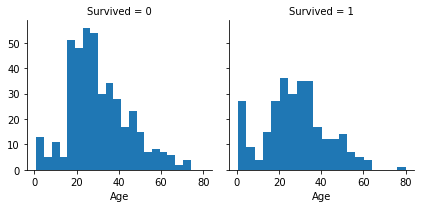

In [12]:
g = sns.FacetGrid(train_df, col = "Survived")
g.map(plt.hist, 'Age', bins = 20)

观察上图可以得出：
1. 在15-30岁之间生存率较低
2. 65 - 80之间生存率几乎为0
3. 30-40之间 1：1

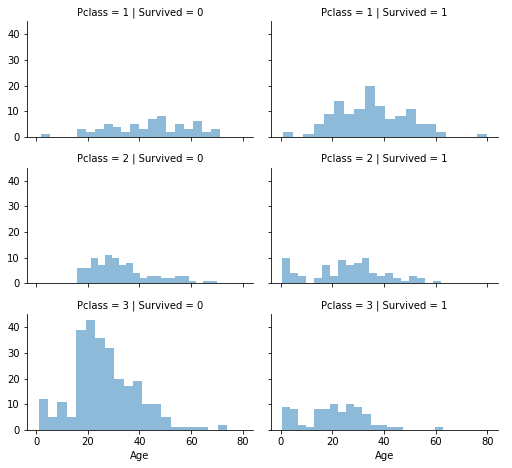

In [13]:
grid = sns.FacetGrid(train_df, col="Survived", row="Pclass", height=2.2, aspect= 1.6)
grid.map(plt.hist, 'Age', alpha = 0.5, bins= 20)
grid.add_legend()

上图可以明显看到 社会等级越高的人越有可能生存下来，等级最低的人生存率极低。

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:720: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


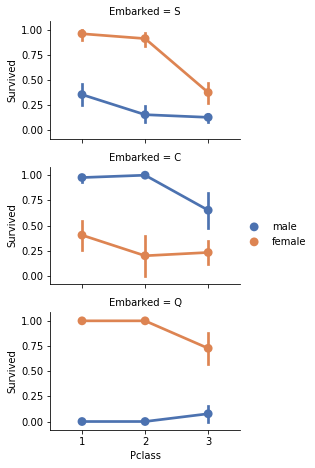

In [14]:
grid = sns.FacetGrid(train_df, row = 'Embarked', height=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

上述数据表明，不同港口出发，不管是等级差异，男女生存率的差别较大。

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


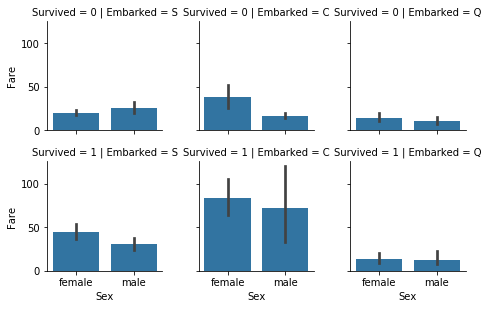

In [15]:
# correlating categorical and numerical features

#Assumption 
# 1. higher fare paying passengers had better survival.
# 2. Port of embarkation

grid  = sns.FacetGrid(train_df, row='Survived', col = 'Embarked', height = 2.2, aspect =1.0)
grid.map(sns.barplot, 'Sex', 'Fare')
grid.add_legend()

上述数据可以表明
1. 存活下来的人，票价较高
2. 不同港口体现了不同的票价
3. 不同港口，男女票价差异有变化

# 数据归类转换，减少类别

In [16]:
print('Before ', train_df.shape, test_df.shape, combine[0].shape, combine[1].shape )

Before  (891, 12) (418, 11) (891, 12) (418, 11)


In [17]:
train_df = train_df.drop(['Ticket', 'Cabin'], axis = 1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis = 1)
combine = [train_df, test_df]
print('After ', train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

After  (891, 10) (418, 9) (891, 10) (418, 9)


In [18]:
# create new feature extracting from existing

for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract('([A-Za-z]+)\.', expand=False)
pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [19]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean().sort_values(by='Survived', ascending =True)

,Title,Survived
2,Mr,0.156673
4,Rare,0.347826
0,Master,0.575000
1,Miss,0.702703
3,Mrs,0.793651


# 数据类型映射

In [20]:
title_mapping = {
    "Mr": 1, "Miss":2, "Mrs":3, "Master":4, "Rare":5
}

for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset["Title"] = dataset['Title'].fillna(0)
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


In [21]:
train_df = train_df.drop(['Name', 'PassengerId'], axis = 1)
test_df = test_df.drop(['Name'], axis = 1)
combine = [train_df, test_df]
print(train_df.shape, test_df.shape)

(891, 9) (418, 9)


In [22]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map({'female': 1, 'male':0}).astype(int)
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


# 处理缺失值
1. 方法一：产生现有数据的均值和标准差的正态分布随机数
2. 方法二：利用其他相关关系来对样本归类，然后取样本的数据的中位数。
3. 结合方法一，方法二，利用较强因子对样本归类，然后分别产生正态分布的随机数

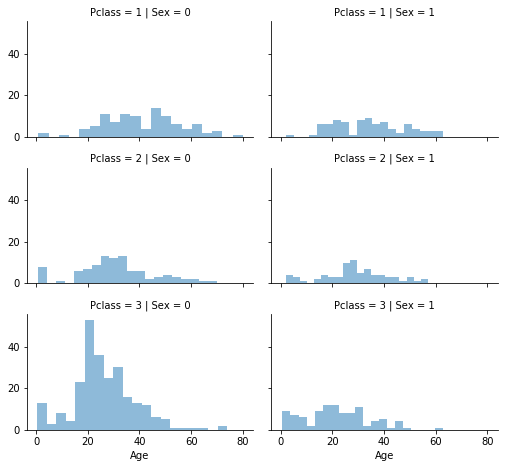

In [23]:
grid = sns.FacetGrid(train_df, row = 'Pclass', col = 'Sex', height = 2.2, aspect = 1.6)
grid.map(plt.hist, 'Age', alpha = 0.5, bins = 20)
grid.add_legend()

针对上述6种情况，填充缺失值。

In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null int32
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    889 non-null object
Title       891 non-null int64
dtypes: float64(2), int32(1), int64(5), object(1)
memory usage: 59.2+ KB


In [25]:
import numpy as np
guess_ages = np.zeros((2,3,2))
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[ (dataset['Sex'] == i) & (dataset['Pclass'] == j + 1)]['Age'].dropna()
            
            age_mean = guess_df.mean()
            age_std = guess_df.std()
            guess_ages[i, j, 0]  = age_mean
            guess_ages[i, j, 1] = age_std

    for i in range(0, 2):
        for j in range(0, 3):
            val = np.random.uniform(guess_ages[i][j][0],guess_ages[i][j][1])
            print(val)
            dataset.loc[(dataset.Age.isnull()) & (dataset.Sex == i) & \
                        (dataset.Pclass == j+1), 'Age'] = val
    dataset['Age'] = dataset['Age'].astype(int)        
    dataset.info()

19.39132645694394
16.668842665627785
13.404588207451829
31.439477375376228
27.706751638678572
15.982111909977181
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null int32
Age         891 non-null int32
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    889 non-null object
Title       891 non-null int64
dtypes: float64(1), int32(2), int64(5), object(1)
memory usage: 55.8+ KB
16.747091902215402
27.67951113883017
20.333603090948326
27.953024433555896
15.217948811446316
13.097654804517234
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null int32
Age            418 non-null int32
SibSp          418 non-null int64
Parch          418 non-null int64
Fare   

In [26]:
train_df["Embarked"] = train_df['Embarked'].fillna("S")
train_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1
5,0,3,0,13,0,0,8.4583,Q,1
6,0,1,0,54,0,0,51.8625,S,1
7,0,3,0,2,3,1,21.0750,S,4
8,1,3,1,27,0,2,11.1333,S,3
9,1,2,1,14,1,0,30.0708,C,3


In [27]:
train_df['AgeBand'] = pd.cut(train_df['Age'] , 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'],
                    as_index = False).mean().sort_values(by="Survived", ascending=True)

,AgeBand,Survived
4,"(64.0, 80.0]",0.090909
0,"(-0.08, 16.0]",0.371429
1,"(16.0, 32.0]",0.381579
2,"(32.0, 48.0]",0.403226
3,"(48.0, 64.0]",0.434783


In [28]:
for dataset in combine:
    dataset.loc[dataset['Age'] < 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32 )& (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,0,1,1,0,7.2500,S,1,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,C,3,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,S,2,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,S,3,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,S,1,"(32.0, 48.0]"


# 从现有特征挖掘新特征

In [29]:
for dataset in combine:
    dataset["FamilySize"] = dataset["SibSp"] + dataset["Parch"] + 1
train_df[["FamilySize", 'Survived']].groupby(['FamilySize'], 
                as_index = False).mean().sort_values(by="Survived", ascending = True)

,FamilySize,Survived
7,8,0.000000
8,11,0.000000
5,6,0.136364
4,5,0.200000
0,1,0.303538
6,7,0.333333
1,2,0.552795
2,3,0.578431
3,4,0.724138


In [30]:
for dataset in combine:
    dataset["IsAlone"] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
train_df[['IsAlone', 'Survived']].groupby(['IsAlone'],
                as_index=False).mean().sort_values(by='Survived', ascending = True)

,IsAlone,Survived
1,1,0.303538
0,0,0.505650


In [31]:
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,AgeBand,IsAlone
0,0,3,0,1,7.2500,S,1,"(16.0, 32.0]",0
1,1,1,1,2,71.2833,C,3,"(32.0, 48.0]",0
2,1,3,1,1,7.9250,S,2,"(16.0, 32.0]",1
3,1,1,1,2,53.1000,S,3,"(32.0, 48.0]",0
4,0,3,0,2,8.0500,S,1,"(32.0, 48.0]",1


In [32]:
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null int32
Age         891 non-null int32
Fare        891 non-null float64
Embarked    891 non-null object
Title       891 non-null int64
AgeBand     891 non-null category
IsAlone     891 non-null int64
dtypes: category(1), float64(1), int32(2), int64(4), object(1)
memory usage: 49.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null int32
Age            418 non-null int32
Fare           417 non-null float64
Embarked       418 non-null object
Title          418 non-null int64
IsAlone        418 non-null int64
dtypes: float64(1), int32(2), int64(4), object(1)
memory usage: 22.9+ KB


In [33]:
test_df["Fare"] = test_df["Fare"].fillna(10)

In [34]:
train_df.info()
for dataset in combine:
    dataset["Age * Class"] = dataset.Age * dataset.Pclass
train_df.loc[:, ["Age * Class", 'Age', "Pclass"]].head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null int32
Age         891 non-null int32
Fare        891 non-null float64
Embarked    891 non-null object
Title       891 non-null int64
AgeBand     891 non-null category
IsAlone     891 non-null int64
dtypes: category(1), float64(1), int32(2), int64(4), object(1)
memory usage: 49.8+ KB


,Age * Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,0,0,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


In [35]:
freq_port = train_df.Embarked.dropna().mode()[0]
freq_port
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'],
        as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [36]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,AgeBand,IsAlone,Age * Class
0,0,3,0,1,7.2500,0,1,"(16.0, 32.0]",0,3
1,1,1,1,2,71.2833,1,3,"(32.0, 48.0]",0,2
2,1,3,1,1,7.9250,0,2,"(16.0, 32.0]",1,3
3,1,1,1,2,53.1000,0,3,"(32.0, 48.0]",0,2
4,0,3,0,2,8.0500,0,1,"(32.0, 48.0]",1,6


In [37]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age * Class
0,892,3,0,2,7.8292,2,1,1,6
1,893,3,1,2,7.0000,0,3,0,6
2,894,2,0,3,9.6875,2,1,1,6
3,895,3,0,1,8.6625,0,1,1,3
4,896,3,1,1,12.2875,0,3,0,3


In [38]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], 
    as_index=False).mean().sort_values(by='FareBand', ascending=True)

for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]
    
train_df.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,AgeBand,IsAlone,Age * Class
0,0,3,0,1,0,0,1,"(16.0, 32.0]",0,3
1,1,1,1,2,3,1,3,"(32.0, 48.0]",0,2
2,1,3,1,1,1,0,2,"(16.0, 32.0]",1,3
3,1,1,1,2,3,0,3,"(32.0, 48.0]",0,2
4,0,3,0,2,1,0,1,"(32.0, 48.0]",1,6
5,0,3,0,0,1,2,1,"(-0.08, 16.0]",1,0
6,0,1,0,3,3,0,1,"(48.0, 64.0]",1,3
7,0,3,0,0,2,0,4,"(-0.08, 16.0]",0,0
8,1,3,1,1,1,0,3,"(16.0, 32.0]",0,3
9,1,2,1,0,2,1,3,"(-0.08, 16.0]",0,0


# Model, Predict and Solve

In [39]:
Y_train = train_df["Survived"]
X_train = train_df.drop("Survived", axis = 1)
X_test = test_df.drop("PassengerId", axis = 1).copy()

print(X_train.shape, Y_train.shape, X_test.shape)
print(X_train.head())
print(X_test.head())

(891, 9) (891,) (418, 8)
   Pclass  Sex  Age  Fare  Embarked  Title       AgeBand  IsAlone  Age * Class
0       3    0    1     0         0      1  (16.0, 32.0]        0            3
1       1    1    2     3         1      3  (32.0, 48.0]        0            2
2       3    1    1     1         0      2  (16.0, 32.0]        1            3
3       1    1    2     3         0      3  (32.0, 48.0]        0            2
4       3    0    2     1         0      1  (32.0, 48.0]        1            6
   Pclass  Sex  Age  Fare  Embarked  Title  IsAlone  Age * Class
0       3    0    2     0         2      1        1            6
1       3    1    2     0         0      3        0            6
2       2    0    3     1         2      1        1            6
3       3    0    1     1         0      1        1            3
4       3    1    1     1         0      3        0            3


In [40]:
X_train.info()
#X_train = X_train.drop("Survived", axis = 1)
X_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Pclass         891 non-null int64
Sex            891 non-null int32
Age            891 non-null int32
Fare           891 non-null int32
Embarked       891 non-null int32
Title          891 non-null int64
AgeBand        891 non-null category
IsAlone        891 non-null int64
Age * Class    891 non-null int64
dtypes: category(1), int32(4), int64(4)
memory usage: 42.8 KB


,Pclass,Sex,Age,Fare,Embarked,Title,AgeBand,IsAlone,Age * Class
0,3,0,1,0,0,1,"(16.0, 32.0]",0,3
1,1,1,2,3,1,3,"(32.0, 48.0]",0,2
2,3,1,1,1,0,2,"(16.0, 32.0]",1,3
3,1,1,2,3,0,3,"(32.0, 48.0]",0,2
4,3,0,2,1,0,1,"(32.0, 48.0]",1,6


In [41]:
X_train.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Pclass         891 non-null int64
Sex            891 non-null int32
Age            891 non-null int32
Fare           891 non-null int32
Embarked       891 non-null int32
Title          891 non-null int64
AgeBand        891 non-null category
IsAlone        891 non-null int64
Age * Class    891 non-null int64
dtypes: category(1), int32(4), int64(4)
memory usage: 42.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
Pclass         418 non-null int64
Sex            418 non-null int32
Age            418 non-null int32
Fare           418 non-null int32
Embarked       418 non-null int32
Title          418 non-null int64
IsAlone        418 non-null int64
Age * Class    418 non-null int64
dtypes: int32(4), int64(4)
memory usage: 19.7 KB


In [42]:
X_train = X_train.drop("AgeBand", axis = 1)
X_train 

,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age * Class
0,3,0,1,0,0,1,0,3
1,1,1,2,3,1,3,0,2
2,3,1,1,1,0,2,1,3
3,1,1,2,3,0,3,0,2
4,3,0,2,1,0,1,1,6
5,3,0,0,1,2,1,1,0
6,1,0,3,3,0,1,1,3
7,3,0,0,2,0,4,0,0
8,3,1,1,1,0,3,0,3
9,2,1,0,2,1,3,0,0


In [43]:
X_train.head(20)

,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age * Class
0,3,0,1,0,0,1,0,3
1,1,1,2,3,1,3,0,2
2,3,1,1,1,0,2,1,3
3,1,1,2,3,0,3,0,2
4,3,0,2,1,0,1,1,6
5,3,0,0,1,2,1,1,0
6,1,0,3,3,0,1,1,3
7,3,0,0,2,0,4,0,0
8,3,1,1,1,0,3,0,3
9,2,1,0,2,1,3,0,0


In [44]:
X_test.head(20)

,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age * Class
0,3,0,2,0,2,1,1,6
1,3,1,2,0,0,3,0,6
2,2,0,3,1,2,1,1,6
3,3,0,1,1,0,1,1,3
4,3,1,1,1,0,3,0,3
5,3,0,0,1,0,1,1,0
6,3,1,1,0,2,2,1,3
7,2,0,1,2,0,1,0,2
8,3,1,1,0,1,3,1,3
9,3,0,1,2,0,1,0,3


In [45]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

cv_log = cross_val_score(logreg, X_train, Y_train, cv = 10, n_jobs = 1)
np.mean(cv_log)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

0.7799560208829871

In [46]:
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,2.176422
5,Title,0.407000
4,Embarked,0.299140
6,AgeBand,0.052533
7,IsAlone,0.021892
3,Fare,-0.037090
2,Age,-0.080466
0,Pclass,-1.005838
8,Age * Class,NaN


In [47]:
# Support Vector Machines

svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

cv_svc = cross_val_score(svc, X_train, Y_train, cv = 10, n_jobs = 1)
np.mean(cv_svc)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

0.8114689025082283

In [48]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn
cv_knn = cross_val_score(knn, X_train, Y_train, cv = 10, n_jobs = 1)
np.mean(cv_knn)

0.7992092271024855

In [49]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian
cv_gaussian = cross_val_score(gaussian, X_train, Y_train, cv = 10, n_jobs = 1)
np.mean(cv_gaussian)

0.7643879809329247

In [50]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron
cv_perceptron = cross_val_score(perceptron, X_train, Y_train, cv = 10, n_jobs = 1)
np.mean(cv_perceptron)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol

0.6770976620133924

In [51]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

cv_lsvc = cross_val_score(linear_svc, X_train, Y_train, cv = 10, n_jobs = 1)
np.mean(cv_lsvc)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

0.783314606741573

In [52]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

cv_sgd = cross_val_score(sgd, X_train, Y_train, cv = 10, n_jobs = 1)
np.mean(cv_sgd)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=

0.6993825899443876

In [53]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree
cv_dtree = cross_val_score(decision_tree, X_train, Y_train, cv = 10, n_jobs = 1)
np.mean(cv_dtree)

0.814877142208603

In [54]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
print(acc_random_forest)
cv_forest = cross_val_score(random_forest, X_train, Y_train, cv = 10, n_jobs = 1)
np.mean(cv_forest)

87.32


0.813741062308478

In [151]:
# adaboost

adaboost_classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 3), 
                                        algorithm = "SAMME", n_estimators = 50)
adaboost_classifier.fit(X_train, Y_train)
Y_pred = adaboost_classifier.predict(X_test)
cv_adaboost = cross_val_score(adaboost_classifier, X_train, Y_train, cv=10, n_jobs =1)
np.mean(cv_adaboost)

0.8138290205425036

# Model Evaluation

In [55]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,87.32
8,Decision Tree,87.32
1,KNN,84.85
0,Support Vector Machines,84.06
5,Perceptron,79.01
7,Linear SVC,78.45
2,Logistic Regression,78.00
4,Naive Bayes,76.43
6,Stochastic Gradient Decent,66.11


In [92]:
# Some useful parameters which will come in handy later on
ntrain = X_train.shape[0]
ntest = X_test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits= NFOLDS)
print(kf)
# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

KFold(n_splits=5, random_state=None, shuffle=False)


In [114]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    i = 0
    # 通过Kfold 进行 NFOLDS 次分裂，每一次分裂
    # 获得一个训练子集，训练模型
    # 一个预测子集输出预测结果，预测结果作为新的训练集
    # 然后模型预测初始的测试集，然后作为新的测试集
    x_train = x_train.values
    y_train = y_train.values
    x_test = x_test.values
    for train_index, test_index in kf.split(x_train):
        x_tr, x_te = x_train[train_index], x_train[test_index]
        y_tr = y_train[train_index]
        clf.fit(x_tr, y_tr)
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
        i += 1
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)
get_oof(random_forest, X_train, Y_train, X_test)

(array([[0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
      

In [135]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 50,
    'learning_rate' : 0.75
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
}
# decision tree
dec_tree_params = {
    'max_depth': 3,
    'min_samples_split': 2
}

In [138]:
rf = SklearnHelper(clf = RandomForestClassifier, seed=SEED, params = rf_params)
ada = SklearnHelper(clf = AdaBoostClassifier, seed=SEED, params=ada_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)
dec_tree = SklearnHelper(clf=DecisionTreeClassifier, seed = SEED, params = dec_tree_params)

In [140]:
rf_oof_train, rf_oof_test = get_oof(rf, X_train, Y_train, X_test)
ada_oof_train, ada_oof_test = get_oof(ada, X_train, Y_train, X_test)
svc_oof_train, svc_oof_test = get_oof(svc, X_train, Y_train, X_test)
dec_oof_train, dec_oof_test = get_oof(dec_tree, X_train, Y_train, X_test)
print("training done!")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:308: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:308: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:308: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:308: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.p

training done!


In [143]:
rf_feature = rf.feature_importances(X_train,Y_train)
#svc_feature = svc.feature_importances(X_train, Y_train)
ada_feature = ada.feature_importances(X_train, Y_train)
dec_feature = dec_tree.feature_importances(X_train,Y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:308: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


[0.16630557 0.23845753 0.04731817 0.1067073  0.04041985 0.29275665
 0.030292   0.07774291]
[0.12 0.04 0.14 0.14 0.1  0.22 0.06 0.18]
[0.20361715 0.         0.01315426 0.04292573 0.         0.73745654
 0.         0.00284633]


In [144]:
base_predictions_train = pd.DataFrame(
    {"RandomForest": rf_oof_train.ravel(), "AdaBoost": ada_oof_train.ravel(),
    "SVC": svc_oof_train.ravel(), "DecisionTree": dec_oof_train.ravel()})
base_predictions_train.head()

,RandomForest,AdaBoost,SVC,DecisionTree
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,0.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


In [147]:
x_train = np.concatenate((rf_oof_train, ada_oof_train, svc_oof_train, 
                    dec_oof_train), axis = 1)
x_test = np.concatenate((rf_oof_test, ada_oof_test, svc_oof_test,
                       dec_oof_test), axis = 1)

In [148]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, Y_train)
predictions = gbm.predict(x_test)

In [169]:
print(X_train.head())
X_train  = X_train.drop("Age * Class", axis = 1)
X_test = X_test.drop("Age * Class", axis = 1)

   Pclass  Sex  Age  Fare  Embarked  Title  IsAlone  Age * Class
0       3    0    1     0         0      1        0            3
1       1    1    2     3         1      3        0            2
2       3    1    1     1         0      2        1            3
3       1    1    2     3         0      3        0            2
4       3    0    2     1         0      1        1            6


In [170]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1)
gbm.fit(X_train, Y_train)
Y_pred = gbm.predict(X_test)
print("Done! ")


Done! 


In [171]:
submission = pd.DataFrame({
        "PassengerID": test_df["PassengerId"],
        "Survived": Y_pred
 })
print("Done!")
submission.to_csv('./gender_submission.csv', index=False)

Done!
